In [10]:
import numpy as np
import pandas as pd
import os
import glob

#Sci-kit
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Torch
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor


#xg-boost
import xgboost as xgb


#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [11]:
filePath = "../data/raw/5G-production-dataset/Download/Driving/"
emptyData = "-"
dependentCol = "UL_bitrate"

fileNames = glob.glob(os.path.join(filePath , "*.csv"))

dataFrames = []

for fileName in fileNames:
    df = pd.read_csv(fileName, index_col=None, header=0, na_values = "-")
    dataFrames.append(df)
df = pd.concat(dataFrames, axis=0, ignore_index=True)


In [12]:
### SELECT COLUMNS ###
selectedFloatCols = ["Longitude", "Latitude", "Speed", "RSRP","RSRQ","SNR"]
selectedCatCols = ["CellID"]
# selectedCatCols = []

selectedCols = selectedFloatCols + selectedCatCols
selectedCols.append(dependentCol)
df = df[selectedCols].dropna()


In [13]:
### DATA PREPARATION ###
#one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' for avoiding multicollinearity
encoded = encoder.fit_transform(df[selectedCatCols])
catData = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(selectedCatCols)).reset_index(drop=True)


#z-score normalization
floatDataUnnormalized = df.drop(selectedCatCols+[dependentCol], axis=1).reset_index(drop=True)
floatData = (floatDataUnnormalized-floatDataUnnormalized.mean())/floatDataUnnormalized.std()
dataX = pd.concat([floatData,catData], axis=1).astype(np.float32)
dataY = df[dependentCol].astype(np.float32)


In [14]:
### DIVIDE INTO TRAINING, VALIDATION AND TEST ###
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size=1 - train_ratio)
xVal, xTest, yVal, yTest = train_test_split(xTest, yTest, test_size=test_ratio/(test_ratio + validation_ratio))


In [15]:
class ThroughputPredictor(nn.Module):
    def __init__(self, input_size):
        super(ThroughputPredictor, self).__init__()
        
        # Define layers (no normalization layer)
        self.fc1 = nn.Linear(input_size, 64)  # First dense layer
        self.fc2 = nn.Linear(64, 64)          # Second dense layer
        self.fc3 = nn.Linear(64, 1)           # Final dense layer (single output)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))           # First dense layer + ReLU
        x = torch.relu(self.fc2(x))           # Second dense layer + ReLU
        x = self.fc3(x)                       # Final dense layer (no activation)
        return x.squeeze(-1) 

In [16]:
### SELECT MODELS ###
rf = RandomForestRegressor(random_state=42)

paramGridRf = {
    # 'n_estimators': [100, 300, 500],        # Number of trees in the forest
    # 'max_depth': [None, 10, 20, 30],        # Maximum depth of the tree
    # 'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 4],          # Minimum number of samples required to be at a leaf node
    # 'max_features': ['sqrt', 'log2']        # Number of features to consider when looking for the best split
    'n_estimators': [300],        # Number of trees in the forest
    'max_depth': [20],        # Maximum depth of the tree
    'min_samples_split': [5],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],          # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt']        # Number of features to consider when looking for the best split
}

xGradBoost = xgb.XGBRegressor(random_state=42)

# Define the parameter grid for XGBoost
paramGridXgb = {
    # 'n_estimators': [100, 200, 300],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'max_depth': [3, 6, 9],
    # 'subsample': [0.8, 1.0],
    # 'colsample_bytree': [0.8, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.01, 0.1],
    # 'reg_lambda': [1, 1.5, 2]

    'n_estimators': [200],
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'reg_alpha': [0.01],
    'reg_lambda': [1.5]
}

net = NeuralNetRegressor(
    ThroughputPredictor,
    module__input_size=dataX.shape[1],  # Pass the input size to the module
    optimizer=optim.Adam,               # Optimizer
    criterion=nn.MSELoss,               # Loss function
    verbose=0,                          # Silence verbose output
    train_split=None                    # Disable internal train/val split, we'll use external CV
)

paramGridNet = {
    # 'lr': [0.01, 0.001],                            # Learning rates to try
    # 'max_epochs': [50, 100],                        # Number of epochs to train
    # 'optimizer__weight_decay': [0, 0.01, 0.001],    # L2 regularization
    # 'batch_size': [16, 32, 64]                      # Batch sizes to try
    # 'lr': [0.001,0.01],
    # 'max_epochs': [5,50],
    # 'optimizer__weight_decay': [0.01],
    # 'batch_size': [32],
    'lr': [0.01],
    'max_epochs': [50],
    'optimizer__weight_decay': [0.01],
    'batch_size': [32]
}

models = {net: paramGridNet, rf: paramGridRf, xGradBoost:paramGridXgb}


In [17]:
def plotErrors(errors, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=False, bins=50, color='skyblue', stat='density', label='Test Errors')

    # Fit a normal distribution to the data
    mu, std = norm.fit(errors)

    # Plot the best-fit normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label=f'Normal fit: μ={mu:.2f}, σ={std:.2f}')

    plt.xlabel('Test Error')
    plt.ylabel('Density')
    plt.title('Histogram of Test Errors with Best-Fit Normal Curve: ' + title)
    plt.legend()


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **

Best Parameters: {'batch_size': 32, 'lr': 0.01, 'max_epochs': 50, 'optimizer__weight_decay': 0.01}
Training MSE: 7706.87
Training R^2: 0.22
Validation MSE: 8647.93
Validation R^2: 0.15
Test MSE: 7836.60
Test R^2: 0.11
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training MSE: 3503.96
Training R^2: 0.65
Validation MSE: 6804.82
Validation R^2: 0.33
Test MSE: 6235.55
Test R^2: 0.30
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'subsample': 0.8}
Training MSE: 7116.28
Training R^2: 0.28
Validation MSE: 8039.02
Validation R^2: 0.21
Test MSE: 7332.56
Test R^2: 0.17


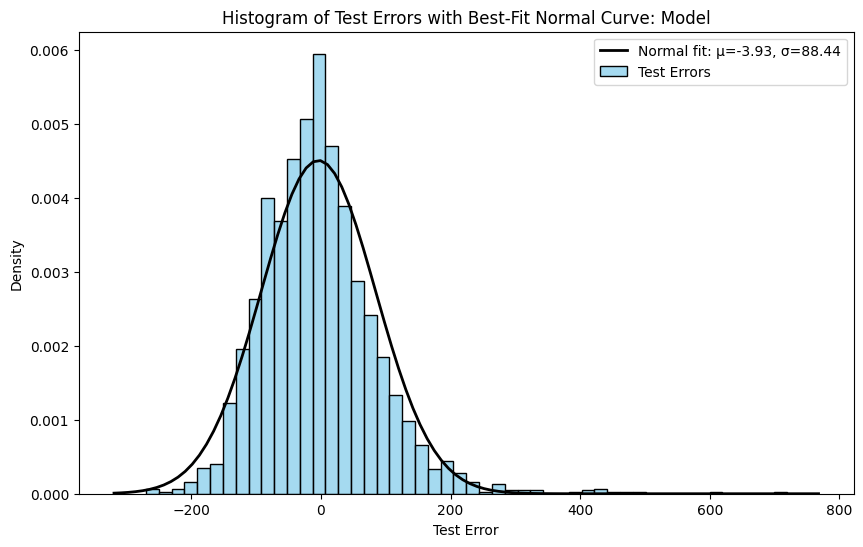

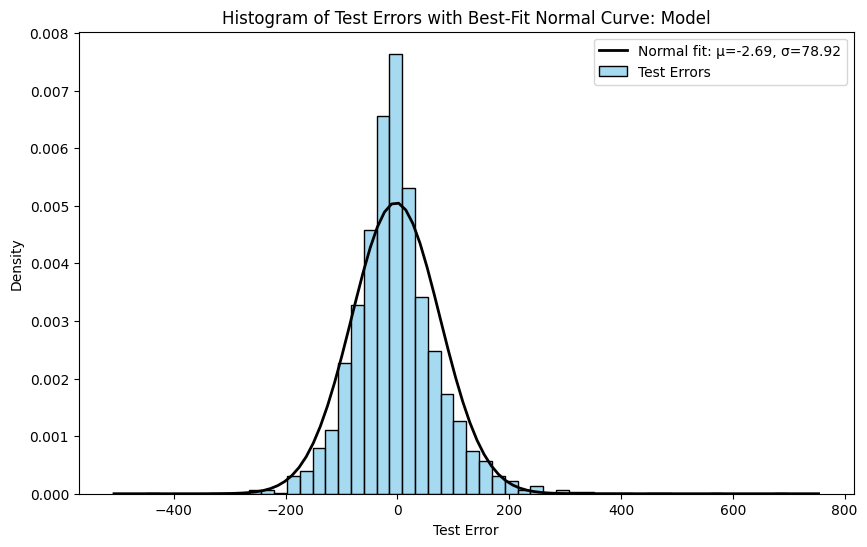

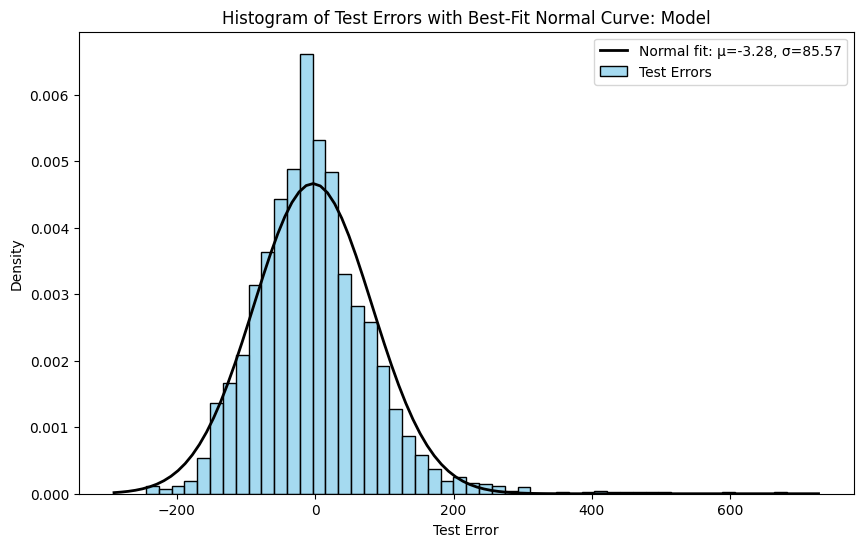

In [18]:
### TRAINING AND EVALUATION###
for model, paramGrid in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=paramGrid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(xTrain.values, yTrain.values)
    rfOptimized = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    # Evaluate on the training data
    yTrainPred = rfOptimized.predict(xTrain.values)
    trainMSE = mean_squared_error(yTrain, yTrainPred)
    trainR2 = r2_score(yTrain, yTrainPred)

    print(f"Training MSE: {trainMSE:.2f}")
    print(f"Training R^2: {trainR2:.2f}")


    # Evaluate on the validation data
    yValPred = rfOptimized.predict(xVal.values)
    valMSE = mean_squared_error(yVal, yValPred)
    valR2 = r2_score(yVal, yValPred)

    print(f"Validation MSE: {valMSE:.2f}")
    print(f"Validation R^2: {valR2:.2f}")


    # Finally, evaluate on the test data
    yTestPred = rfOptimized.predict(xTest.values)
    testMSE = mean_squared_error(yTest, yTestPred)
    testR2 = r2_score(yTest, yTestPred)

    print(f"Test MSE: {testMSE:.2f}")
    print(f"Test R^2: {testR2:.2f}")


    ### CHECK NORMALITY OF ERRORS ###
    errors = yTest - yTestPred
    plotErrors(errors, "Model")
plt.show()
